In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [63]:
import os
import logging
import argparse
import glob
import json
from multiprocessing import Pool

import numpy as np
from matplotlib.ticker import StrMethodFormatter
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown
import statsmodels.api as sm

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config


In [4]:
os.chdir('/home/walml/repos/zoobot')

In [5]:
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
#     'spiral-winding_tight',
#     'spiral-winding_medium',
#     'spiral-winding_loose',
    'bar_strong',
    'bar_weak',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_large',
    'bulge-size_moderate',
    'bulge-size_small',
    'bulge-size_none'
]

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
#     'spiral-winding',
    'bar',
    'bulge-size'
]

schema = losses.Schema(label_cols, questions, version='decals')
schema.questions

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f2fe4796890>: (2, 3), bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7f2fe4796890>: (4, 6), bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f2fe4796890>: (7, 11)}


[smooth-or-featured, indices 0 to 1, asked after None,
 has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7f2fe4796890>,
 bar, indices 4 to 6, asked after <zoobot.estimators.losses.Answer object at 0x7f2fe4796890>,
 bulge-size, indices 7 to 11, asked after <zoobot.estimators.losses.Answer object at 0x7f2fe4796890>]

In [6]:
df_a = pd.read_csv('temp/10k_model_a_predictions.csv')
df_b = pd.read_csv('temp/10k_model_b_predictions.csv')
# df_both = pd.concat([df_a, df_b], axis=0)

In [7]:
df_a['file_loc']

0      /media/walml/beta/decals/png_native/dr5/J114/J...
1      /media/walml/beta/decals/png_native/dr5/J114/J...
2      /media/walml/beta/decals/png_native/dr5/J114/J...
3      /media/walml/beta/decals/png_native/dr5/J115/J...
4      /media/walml/beta/decals/png_native/dr5/J115/J...
                             ...                        
995    /media/walml/beta/decals/png_native/dr5/J152/J...
996    /media/walml/beta/decals/png_native/dr5/J114/J...
997    /media/walml/beta/decals/png_native/dr5/J133/J...
998    /media/walml/beta/decals/png_native/dr5/J130/J...
999    /media/walml/beta/decals/png_native/dr5/J100/J...
Name: file_loc, Length: 1000, dtype: object

In [8]:
df_b['file_loc']

0      /media/walml/beta/decals/png_native/dr5/J114/J...
1      /media/walml/beta/decals/png_native/dr5/J114/J...
2      /media/walml/beta/decals/png_native/dr5/J114/J...
3      /media/walml/beta/decals/png_native/dr5/J115/J...
4      /media/walml/beta/decals/png_native/dr5/J115/J...
                             ...                        
995    /media/walml/beta/decals/png_native/dr5/J152/J...
996    /media/walml/beta/decals/png_native/dr5/J114/J...
997    /media/walml/beta/decals/png_native/dr5/J133/J...
998    /media/walml/beta/decals/png_native/dr5/J130/J...
999    /media/walml/beta/decals/png_native/dr5/J100/J...
Name: file_loc, Length: 1000, dtype: object

(0.0, 0.5)

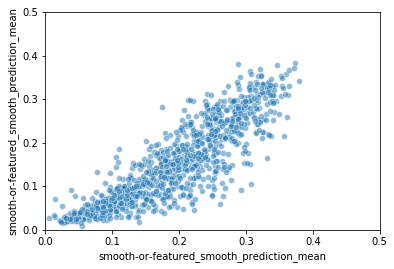

In [9]:
sns.scatterplot(df_a['smooth-or-featured_smooth_prediction_mean'], df_b['smooth-or-featured_smooth_prediction_mean'], alpha=0.5)
plt.xlim([0., 0.5])
plt.ylim([0., 0.5])

(0.0, 1.0)

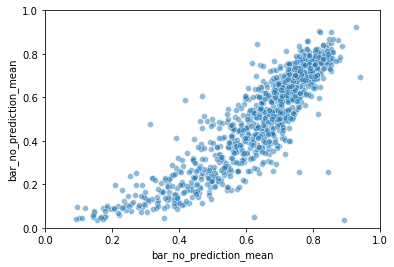

In [10]:
sns.scatterplot(df_a['bar_no_prediction_mean'], df_b['bar_no_prediction_mean'], alpha=0.5)
plt.xlim([0., 1.])
plt.ylim([0., 1.])

In [11]:
def get_samples(df, answer_text):
    return np.array([json.loads(x) for x in df[answer_text + '_prediction']])

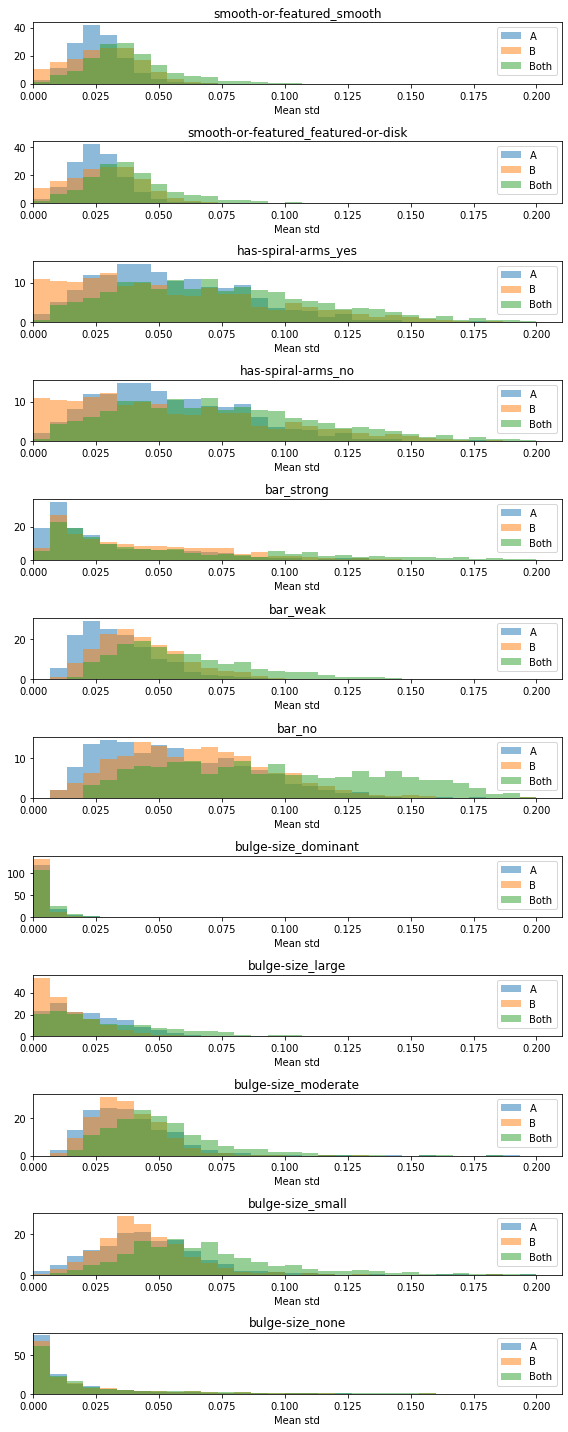

In [12]:
fig, axes = plt.subplots(nrows=len(schema.answers), figsize=(8, 20))

for n, answer in enumerate(schema.answers):
    
    _, bins = np.histogram(np.linspace(0., .2), bins=30)
    
    ax = axes[n]
    answer_text = answer.text
    samples_a = get_samples(df_a, answer_text)
    ax.hist(np.std(samples_a, axis=1), alpha=0.5, density=True, label='A', bins=bins)

    samples_b = get_samples(df_b, answer_text)
    ax.hist(np.std(samples_b, axis=1), alpha=0.5, density=True, label='B', bins=bins)

    samples_both = np.concatenate([samples_a, samples_b], axis=1)
    ax.hist(np.std(samples_both, axis=1), alpha=0.5, density=True, label='Both', bins=bins)

    ax.set_title(answer_text)
    ax.set_xlabel('Mean std')
    ax.set_xlim(0., None)
    
    ax.legend()
    
fig.tight_layout()

In [13]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=3, ncols=3):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            image = Image.open(galaxy['file_loc'])
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(image)
#             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


<Figure size 432x288 with 0 Axes>

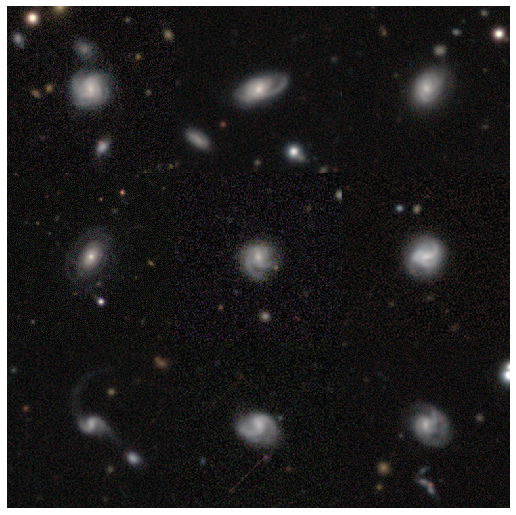

In [14]:
smooth_samples_a = get_samples(df_a, 'smooth-or-featured_smooth')
unc_smooth_a = df_a.iloc[np.argsort(np.std(smooth_samples_a, axis=1))[-10:]]
_ = show_galaxies(unc_smooth_a)

<Figure size 432x288 with 0 Axes>

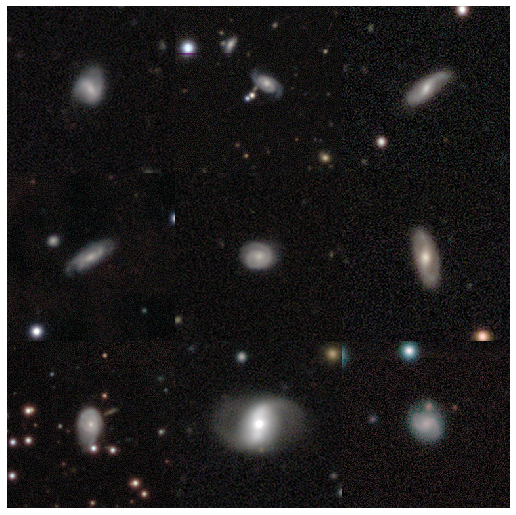

In [15]:
smooth_samples_b = get_samples(df_b, 'smooth-or-featured_smooth')
unc_smooth_b = df_a.iloc[np.argsort(np.std(smooth_samples_b, axis=1))[-10:]]
_ = show_galaxies(unc_smooth_b)

In [16]:
smooth_samples_both = np.concatenate([samples_a, samples_b], axis=1)
np.argsort(np.std(smooth_samples_both, axis=1))[-10:]

array([543, 744, 596, 368, 106, 749, 903, 899, 507, 407])

<Figure size 432x288 with 0 Axes>

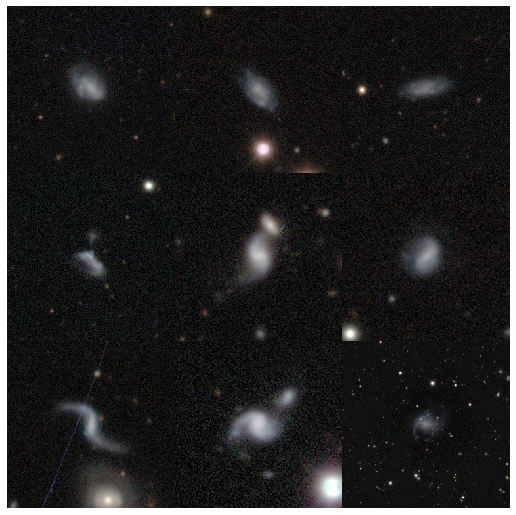

In [17]:
unc_smooth_both = df_a.iloc[np.argsort(np.std(smooth_samples_both, axis=1))[-10:]]  # can use either df, same file_locs
_ = show_galaxies(unc_smooth_both)

<Figure size 432x288 with 0 Axes>

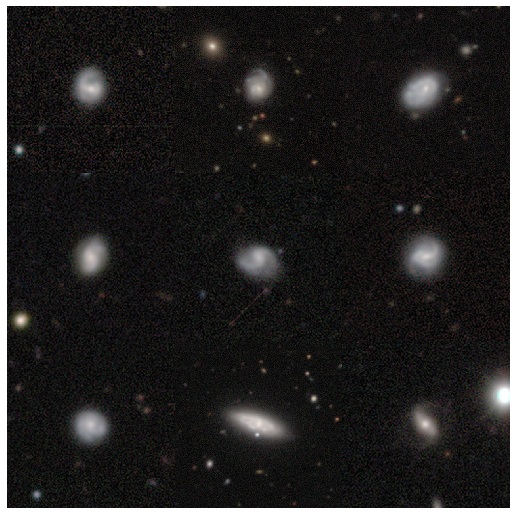

In [18]:
spiral_samples_a = get_samples(df_a, 'has-spiral-arms_yes')
unc_spiral_a = df_a.iloc[np.argsort(np.std(spiral_samples_a, axis=1))[-10:]]  # can use either df, same file_locs
_ = show_galaxies(unc_spiral_a)

<Figure size 432x288 with 0 Axes>

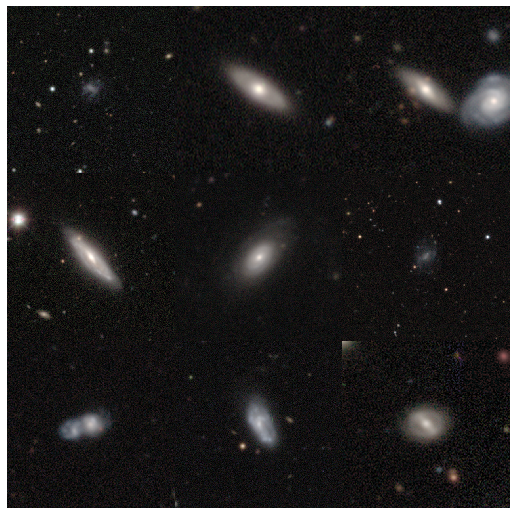

In [19]:
spiral_samples_b = get_samples(df_b, 'has-spiral-arms_yes')
unc_spiral_b = df_a.iloc[np.argsort(np.std(spiral_samples_b, axis=1))[-10:]]  # can use either df, same file_locs
_ = show_galaxies(unc_spiral_b)

<Figure size 432x288 with 0 Axes>

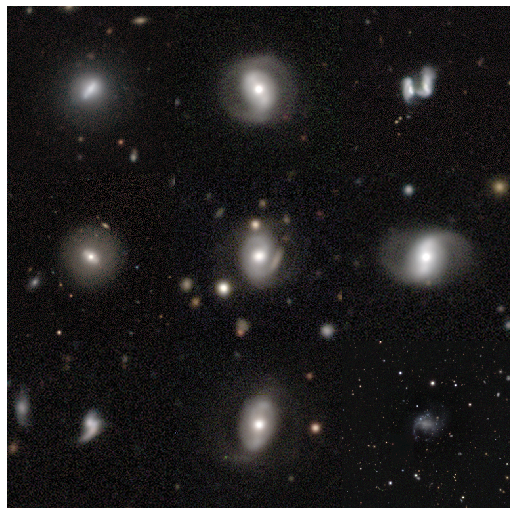

In [20]:
spiral_samples_both = np.concatenate([spiral_samples_a, spiral_samples_b], axis=1)
unc_spiral_both = df_a.iloc[np.argsort(np.std(spiral_samples_both, axis=1))[-10:]]  # can use either df, same file_locs
_ = show_galaxies(unc_spiral_both)

<Figure size 432x288 with 0 Axes>

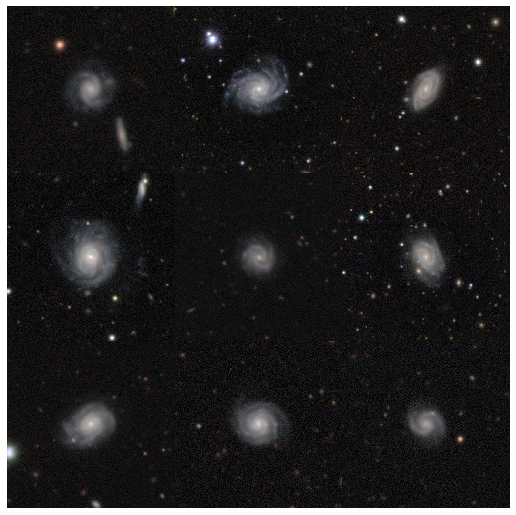

In [21]:
unc_spiral_both = df_a.iloc[np.argsort(np.std(spiral_samples_both, axis=1))[:10]]  # can use either df, same file_locs
_ = show_galaxies(unc_spiral_both)

In [22]:
smooth_acq_a = acquisition_utils.mutual_info_acquisition_func(smooth_samples_a, 40)
smooth_acq_b = acquisition_utils.mutual_info_acquisition_func(smooth_samples_b, 40)

In [23]:
def get_samples_all_answers(df):
    return np.array([np.array([json.loads(x) for x in df[answer + '_prediction']]) for answer in label_cols]).swapaxes(0, 1)

In [24]:
samples_a = get_samples_all_answers(df_a)
acquisition_values_a = acquisition_utils.mutual_info_acquisition_func_multiq(samples_a, schema, retirement=40)

samples_b = get_samples_all_answers(df_b)
acquisition_values_b = acquisition_utils.mutual_info_acquisition_func_multiq(samples_b, schema, retirement=40)


In [25]:
# def combine_samples_all_questions(samples_a, samples_b):
#     assert samples_a.shape == samples_b.shape
#     samples_both = np.zeros((samples_a.shape[0], samples_a.shape[1]*2))
#     for a_n in samples_a.shape[1]:
#         predictions_both = np.concatenate(samples_a[:, n], samples_b[:, n], axis=1)
#         samples_both[:, a_n*2, a_n*2+1] = predictions_both
#     return samples_both


In [26]:

samples_both = np.concatenate([samples_a, samples_b], axis=2)  # treating samples from both models as equivalent, not quite BALD
print(samples_both.shape)
acquisition_values_both = acquisition_utils.mutual_info_acquisition_func_multiq(samples_both, schema, retirement=40)

(1000, 12, 30)


<Figure size 432x288 with 0 Axes>

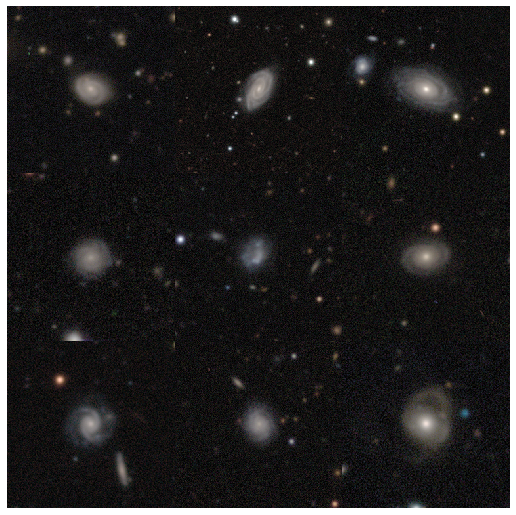

In [27]:

_ = show_galaxies(df_a.iloc[np.argsort(acquisition_values_a.mean(axis=1))][:25], ncols=3, nrows=3)

<Figure size 432x288 with 0 Axes>

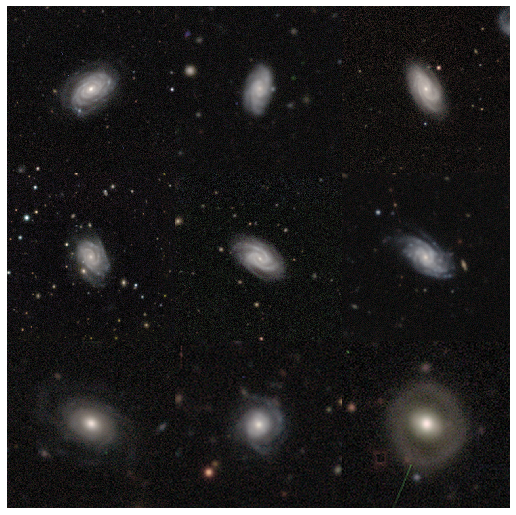

In [28]:

_ = show_galaxies(df_b.iloc[np.argsort(acquisition_values_b.mean(axis=1))][:25], ncols=3, nrows=3)

<Figure size 432x288 with 0 Axes>

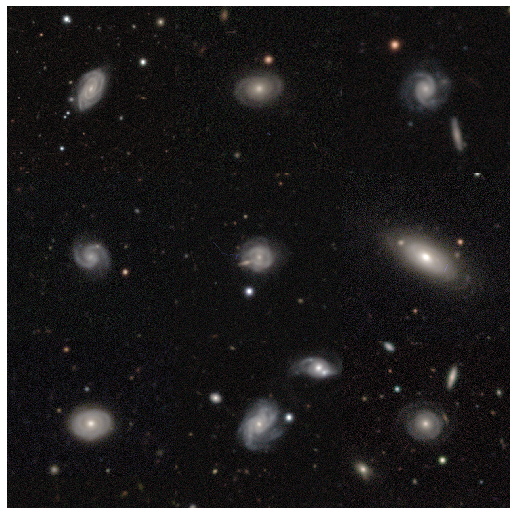

In [29]:

_ = show_galaxies(df_a.iloc[np.argsort(acquisition_values_both.mean(axis=1))][:25], ncols=3, nrows=3)

<Figure size 432x288 with 0 Axes>

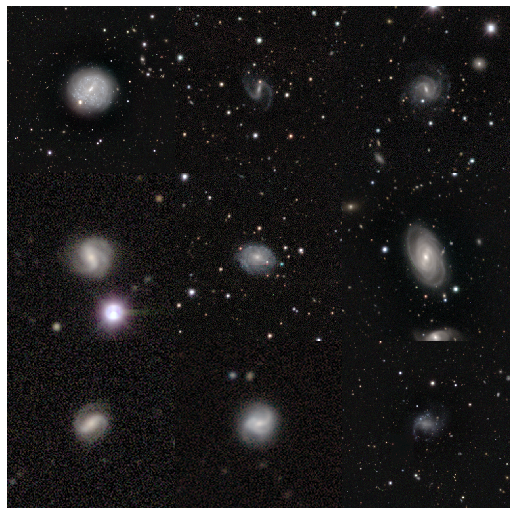

In [30]:

_ = show_galaxies(df_a.iloc[np.argsort(acquisition_values_both.mean(axis=1))][::-1][:25], ncols=3, nrows=3)

1. Show contribution of each question, for rows of galaxies
2. Find entropy in rho for individual models, hence BALD over both? (KDE?)


In [31]:
# samples_both.shape

(1000, 12, 30)

In [32]:
# from copulas.univariate import BetaUnivariate

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


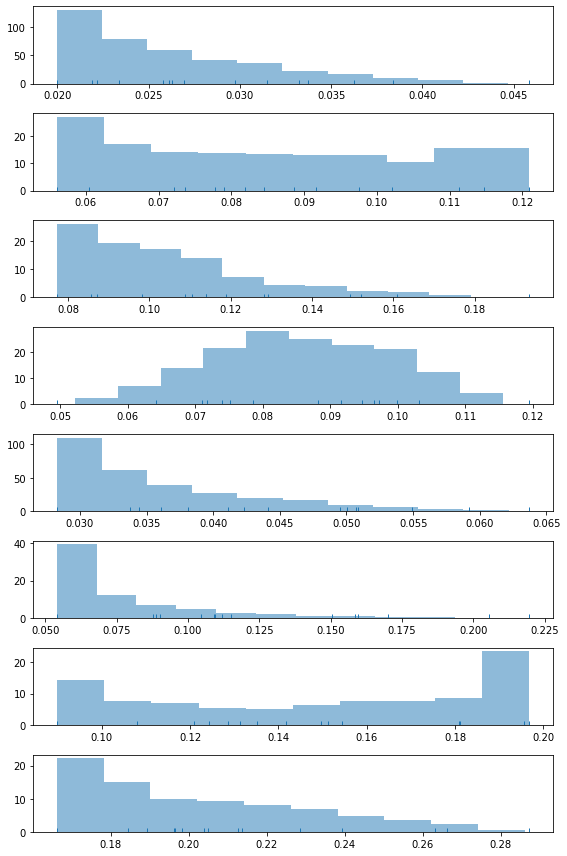

In [33]:
# nrows=8
# fig, axes = plt.subplots(nrows=nrows, figsize=(8, 12))
# for n in range(nrows):
#     ax = axes[n]
#     data = samples_a[n, 8]
#     beta = BetaUnivariate()
#     beta.fit(data)
#     sns.rugplot(data, ax=ax)
#     ax.hist(beta.sample(1000), alpha=0.5, density=True)
# fig.tight_layout()

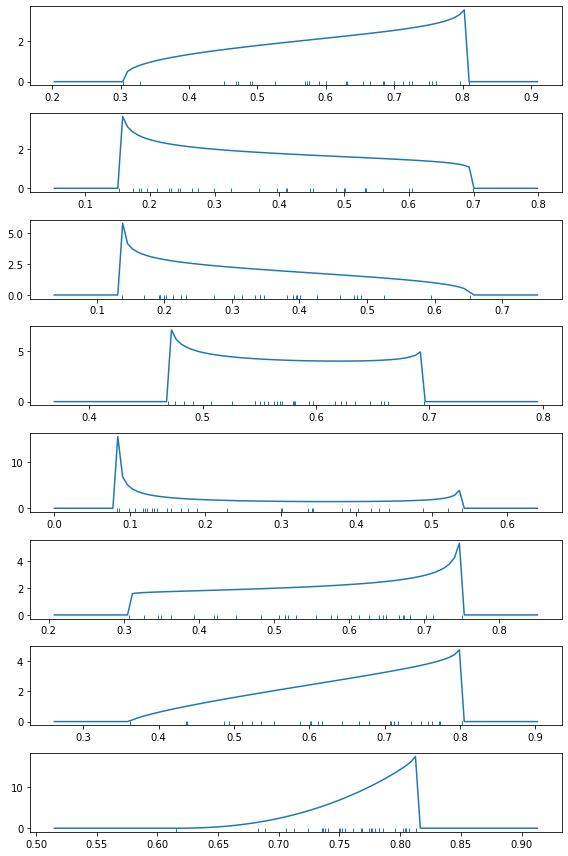

In [34]:
# nrows=8
# answer_n=6
# fig, axes = plt.subplots(nrows=nrows, figsize=(8, 12))
# for n in range(nrows):
#     ax = axes[n]
# #     for samples in [samples_a, samples_b, samples_both]:
#     for samples in [samples_both]:
#         data = samples[n, answer_n]
#         beta = BetaUnivariate()
#         beta.fit(data)
#         sns.rugplot(data, ax=ax)
#         low = max(0., samples_both[n, answer_n].min()-.1)
#         high = min(1., samples_both[n, answer_n].max()+.1)
#         x = np.linspace(low, high, 100)
#         ax.plot(x, beta.pdf(x))
# fig.tight_layout()

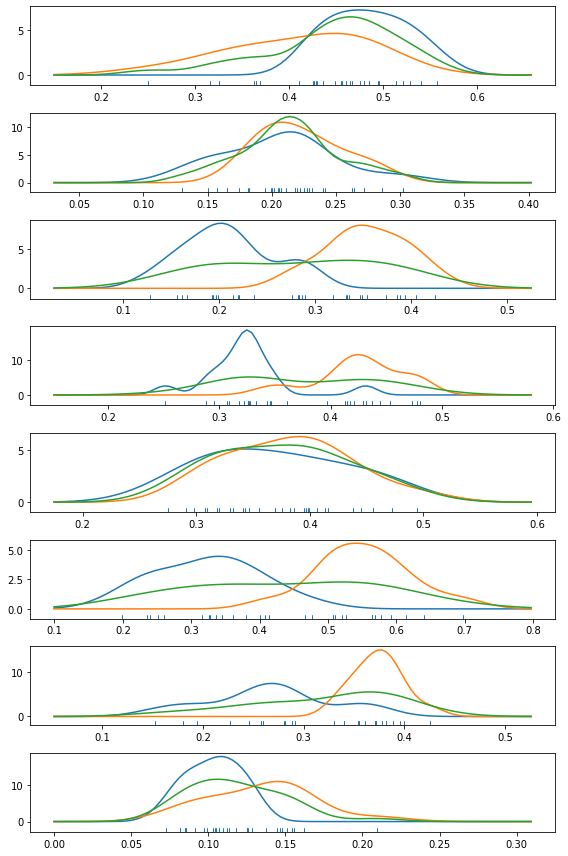

In [35]:
# nrows=8
# answer_n=10
# fig, axes = plt.subplots(nrows=nrows, figsize=(8, 12))
# mean_e = np.zeros((nrows, 3))
# for n in range(nrows):
#     ax = axes[n]
#     for model_n, samples in enumerate([samples_a, samples_b, samples_both]):
# #     for samples in [samples_both]:
#         data = samples[n, answer_n]
#         dens = sm.nonparametric.KDEUnivariate(data)
#         dens.fit()
#         sns.rugplot(data, ax=ax)
#         low = max(0., samples_both[n, answer_n].min()-.1)
#         high = min(1., samples_both[n, answer_n].max()+.1)
#         x = np.linspace(low, high, 100)
#         ax.plot(x, dens.evaluate(x))
#         mean_e[n, model_n] = dens.entropy
# fig.tight_layout()

In [37]:
# %timeit dens = sm.nonparametric.KDEMultivariate(data.reshape(-1, 1), var_type='c', bw='cv_ml')

19 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


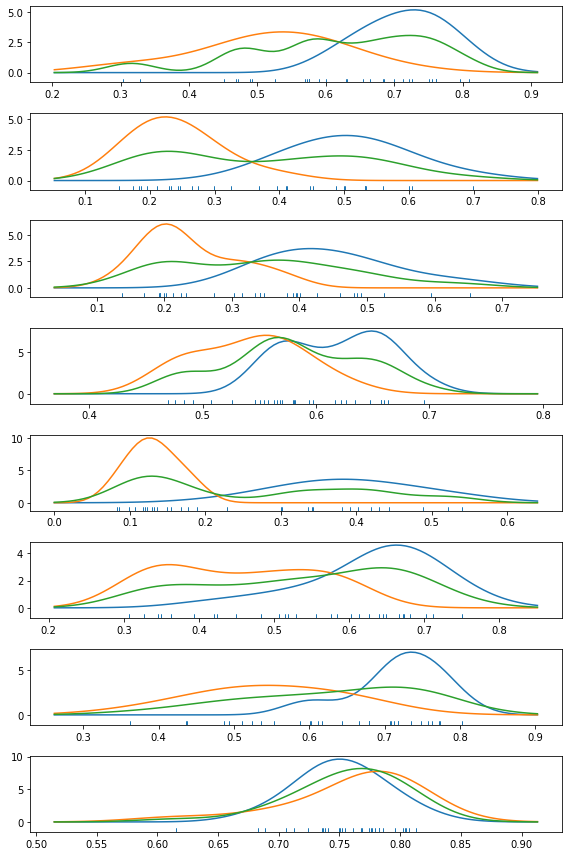

In [38]:
# nrows=8
# answer_n=6
# fig, axes = plt.subplots(nrows=nrows, figsize=(8, 12))
# for n in range(nrows):
#     ax = axes[n]
#     for samples in [samples_a, samples_b, samples_both]:
# #     for samples in [samples_both]:
#         data = samples[n, answer_n]
#         dens = sm.nonparametric.KDEMultivariate(data.reshape(-1, 1), var_type='c', bw='cv_ml')
# #         dens.fit()
#         sns.rugplot(data, ax=ax)
#         low = max(0., samples_both[n, answer_n].min()-.1)
#         high = min(1., samples_both[n, answer_n].max()+.1)
#         x = np.linspace(low, high, 100)
#         ax.plot(x, dens.pdf(x.reshape(-1,1)))
# fig.tight_layout()

In [88]:
# def get_kde(x):
#     assert x.ndim == 1
#     return sm.nonparametric.KDEMultivariate(x.reshape(-1, 1), var_type='c', bw='cv_ml')

def get_kde(x, **kwargs):
    dens = sm.nonparametric.KDEUnivariate(x)
    dens.fit(**kwargs)
    return dens

In [117]:
def get_kde_fast(x, **kwargs):
    # split batch dimension along number line (with gap)
    assert x.ndim == 2
    stretcher = np.array(np.arange(0, len(x) * 2, 2)).reshape((len(x), 1))
    x = x + stretcher
    x = x.flatten()
    # do kde
    dens = sm.nonparametric.KDEUnivariate(x)
    dens.fit(fft=True, **kwargs)
    # patch back again (for debugging)
#     def kde(x, index):
#         return dens.evaluate(x + 2*index)
#     return kde
    return dens

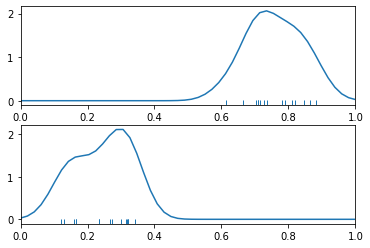

In [90]:
batch = np.array([np.random.uniform(.6, .9, size=15),np.random.uniform(.1, .4, size=15)])
kde = get_kde_fast(batch, bw=.05)
x = np.linspace(0., 1.)
fig, axes = plt.subplots(nrows=len(batch))
for n in range(len(batch)):
    ax = axes[n]
    sns.rugplot(batch[n], ax=ax)
    ax.plot(x, kde(x, n))
    ax.set_xlim(0., 1.)

In [91]:
def differential_entropy(kernel, index, low, high):  # observed are the actual measurements

    def entr(x):
        pdf = kernel(x, index)  # s being observed samples, x being test points. Not sure why it still needs to know s.
        return pdf*np.log(pdf+1e-12)
    
#     https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html
    return -integrate.quad(entr, low, high)[0]


In [92]:
differential_entropy(kde, 0, 0., 1.)

-0.15457930076653348

In [93]:
def get_pdf_with_kde(x, bw=.05):
    
    kernel = get_kde_fast(x, bw=bw)
    
    entropies = np.zeros(len(x))
    for n in range(len(x)):    
        entropies[n]= differential_entropy(kernel, n, 0, 1)
    
    return kernel, entropies

In [95]:
kde, entropies = get_pdf_with_kde(batch)
entropies

array([-0.1545793 , -0.16371078])

In [ ]:
%timeit get_kde(np.random.uniform(size=15)).entropy

In [ ]:
%timeit get_kde(np.random.uniform(size=15), fft=False).entropy

In [ ]:
%timeit get_kde(np.random.uniform(size=150), fft=False).entropy

In [ ]:
%timeit get_kde(np.random.uniform(size=1500), fft=False).entropy

In [ ]:
%timeit get_kde(np.random.uniform(size=1500), fft=True).entropy

In [ ]:
# %timeit get_kde(np.random.uniform(size=15000), fft=True).entropy

In [ ]:
# %timeit get_kde(np.random.uniform(size=240000), fft=True).entropy

In [97]:
%timeit [get_kde(np.random.uniform(size=15), fft=True) for n in range(1000)]

332 ms ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [99]:
%timeit get_kde_fast(np.random.uniform(size=(1000, 15)))

1.89 ms ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [122]:
kde_slow = get_kde(np.random.uniform(size=15), fft=True)
kde_fast = get_kde_fast(np.random.uniform(size=(1000, 15)), gridsize=50)

In [115]:
%timeit kde_slow.evaluate(np.linspace(0., 1.))

58.3 µs ± 302 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [123]:
%timeit kde_fast.evaluate(np.linspace(0., 1.))

13.5 ms ± 42.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [116]:
%timeit kde_fast(np.linspace(0., 1.), 12)

13.5 ms ± 66.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [104]:
%timeit [get_kde(np.random.uniform(size=15), fft=True).entropy for n in range(1000)]

8.27 s ± 82.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
%timeit get_pdf_with_kde(np.random.uniform(size=(1000, 15)))

41.4 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def multimodel_bald(model_predictions, min_entropy=-5.5, max_entropy=10):
#     print(model_predictions.shape)
    # model predictions shape (rho, model)
    individual_entropies = np.array([get_kde(predictions).entropy for predictions in model_predictions])
    mean_individual_entropy = individual_entropies.mean()
    expected_entropy = get_kde(model_predictions.flatten()).entropy
    if individual_entropies.min() < min_entropy:  # occasionally, very nearby predictions can cause insanely spiked kdes
        return np.nan
    elif individual_entropies.max() > max_entropy:
        return np.nan
    else:
        return expected_entropy - mean_individual_entropy

In [ ]:

def get_multimodel_acq(samples_list, n_processes=12):  # e.g. [samples_a, samples_b], each of shape(galaxy, answer, rho)
    samples = np.stack(samples_list, axis=-1)  # add new final axis, which model
    print(samples.shape)
    n_subjects = samples.shape[0]
    n_answers = samples.shape[1]
    acq = np.zeros((n_subjects, n_answers))
    for subject_n in range(n_subjects):
        model_predictions_by_answer = [samples[subject_n, answer_n].transpose() for answer_n in range(n_answers)]  # shape (model, rho)
        with Pool(processes=n_processes) as pool:
            acq_by_answer = pool.map(multimodel_bald, model_predictions_by_answer)
#         acq_by_answer = list(map(multimodel_bald, model_predictions_by_answer))
        acq[subject_n, :] = acq_by_answer
    return acq


In [ ]:
# def get_multimodel_acq(samples_list, n_processes=12):  # e.g. [samples_a, samples_b]
#     # TODO check sample shapes are all equal
#     n_subjects = samples_list[0].shape[0]
#     n_answers =  samples_list[0].shape[1]
#     acq = np.zeros((n_subjects, n_answers))
#     for subject_n in range(n_subjects):
#         model_predictions_by_answer = [np.array([samples_a[subject_n, answer_n], samples_b[subject_n, answer_n]]) for answer_n in range(n_answers)]
#         with Pool(processes=n_processes) as pool:
#             acq_by_answer = pool.map(multimodel_bald, model_predictions_by_answer)
#         acq[subject_n, :] = acq_by_answer
#     return acq

In [ ]:
# %timeit get_kde(np.random.uniform(size=15)).entropy  # 30NQ kdes needed e.g. 1000 galaxies -> ~300000 kdes

In [ ]:
# %timeit multimodel_bald(np.array([samples_a[0, 0], samples_b[0, 0]]))

In [ ]:
0.035 * 1000 * 3 * 10 / 60

In [ ]:
# %timeit acq = get_multimodel_acq([samples_a[:10], samples_b[:10]], n_processes=8)  # 3s

In [ ]:
# get_multimodel_acq([samples_a[:10], samples_b[:10]])

In [ ]:
# %timeit acq = get_multimodel_acq([samples_a[:50], samples_b[:50]], n_processes=8) # 15s

In [ ]:
print(samples_a[:10].shape)

In [ ]:
# multimodel_bald([samples_])

In [ ]:
acq = get_multimodel_acq([samples_a, samples_b], n_processes=8)  # about 6 mins per 1000 galaxies

In [ ]:
acq.shape

In [ ]:
plt.hist(acq[:, 7], bins=20)

In [ ]:
dict(zip([a.text for a in schema.answers], np.around(np.nanmean(acq, axis=0), 2)))

In [ ]:
dict(zip([a.text for a in schema.answers], np.around(np.isnan(acq).mean(axis=0), 2)))

In [ ]:
np.isnan(acq[:, 7]).mean()

In [ ]:
fig, ax = plt.subplots()
alpha = 0.5
ax.hist(df_a['bulge-size_dominant_prediction_mean'], density=True, alpha=alpha)
ax.hist(df_a['bulge-size_large_prediction_mean'], density=True, alpha=alpha)
ax.hist(df_a['bulge-size_moderate_prediction_mean'], density=True, alpha=alpha)
ax.hist(df_a['bulge-size_small_prediction_mean'], density=True, alpha=alpha)
ax.hist(df_a['bulge-size_none_prediction_mean'], density=True, alpha=alpha)

In [ ]:
fig, ax = plt.subplots()
alpha = 0.5
ax.hist(df_a['bulge-size_dominant_prediction_mean'] + df_a['bulge-size_large_prediction_mean'], density=True, alpha=alpha)
ax.hist(df_a['bulge-size_moderate_prediction_mean'], density=True, alpha=alpha)
ax.hist(df_a['bulge-size_small_prediction_mean'] + df_a['bulge-size_none_prediction_mean'], density=True, alpha=alpha)

In [ ]:
# acq.mean(axis=1)

In [ ]:
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
#     'spiral-winding_tight',
#     'spiral-winding_medium',
#     'spiral-winding_loose',
    'bar_strong',
    'bar_weak',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_large',
    'bulge-size_moderate',
    'bulge-size_small',
    'bulge-size_none'
]

In [ ]:
_ = plt.hist(acq.mean(axis=1))

In [ ]:
sns.scatterplot(acq[:, 0], acq[:, 1], hue=np.std(get_samples(df_a, 'smooth-or-featured_smooth'), axis=1), legend=False)  # may need a sense check filter of ignore acq

In [ ]:
acq[:, 0].argmax()

In [ ]:
_ = show_galaxies(df_a.iloc[976:977], nrows=1, ncols=1)

In [ ]:
data = samples_a[976, 0]
sns.rugplot(data)

In [ ]:
data = samples_b[976, 0]
sns.rugplot(data)

In [ ]:

for samples in [samples_a, samples_b, samples_both]:
#     for samples in [samples_both]:
    data = samples[977, 0]
    dens = sm.nonparametric.KDEUnivariate(data)
    dens.fit()
    sns.rugplot(data, ax=ax)
    low = max(0., samples_both[977, 0].min()-.1)
    high = min(1., samples_both[977, 0].max()+.1)
    x = np.linspace(low, high, 100)
    plt.plot(x, dens.evaluate(x))
    print(dens.entropy)
# fig.tight_layout()


In [ ]:

for samples in [samples_a, samples_b, samples_both]:
#     for samples in [samples_both]:
    data = samples[976, 0]
    dens = sm.nonparametric.KDEUnivariate(data)
    dens.fit()
    sns.rugplot(data, ax=ax)
    low = max(0., samples_both[976, 0].min()-.1)
    high = min(1., samples_both[976, 0].max()+.1)
    x = np.linspace(low, high, 100)
    plt.plot(x, dens.evaluate(x))
    print(dens.entropy)
# fig.tight_layout()


In [ ]:
sns.scatterplot(acq[:, 2], acq[:, 3], hue=np.std(get_samples(df_a, 'has-spiral-arms_yes'), axis=1))  # may need a sense check filter of ignore acq

In [ ]:
sns.scatterplot(acq[:, 0], acq[:, 1], hue=np.std(get_samples(df_a, 'smooth-or-featured_smooth'), axis=1))  # may need a sense check filter of ignore acq

In [ ]:

for samples in [samples_a, samples_b, samples_both]:
#     for samples in [samples_both]:
    data = samples[8, 2]
    dens = sm.nonparametric.KDEUnivariate(data)
    dens.fit()
    sns.rugplot(data, ax=ax)
    low = max(0., samples_both[8, 2].min()-.1)
    high = min(1., samples_both[8, 2].max()+.1)
    x = np.linspace(low, high, 100)
    plt.plot(x, dens.evaluate(x))
    print(dens.entropy)
# fig.tight_layout()

In [ ]:
acq_trimmed = acq[:, [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]]  # no 7

In [ ]:
# questions with binary answers must have equal entropy

def check_equal_binary_responses(acq_row, schema):
    binary_questions = [q for q in schema.questions if len(q.answers) == 2]
    for q in binary_questions:
        indices = schema.named_index_groups[q]
        if not np.isclose(acq_row[indices[0]], acq_row[indices[1]], rtol=.01):
            return False
    return True

In [ ]:
equal_binary_responses = [check_equal_binary_responses(row, schema) for row in acq]

In [ ]:
sns.scatterplot(acq[:, 0], acq[:, 1], hue=equal_binary_responses)

In [ ]:
acq_trimmed = acq.copy()
acq_trimmed[:, 7] = 0  # ignore bulge domimant
acq_trimmed[:, 11] = 0  # ignore bulge no

In [ ]:
def check_valid_acq(acq_values):
    return np.all(acq_values > -.5, axis=1)

In [ ]:
def get_sort_indices(acq_values, schema):
    assert acq_values.ndim == 2
    acq_values_mean = np.nanmean(acq_values, axis=1)
    indices = np.argsort(acq_values_mean)
    # remove nan
    not_nan = ~np.isnan(acq_values.mean(axis=1))  # i.e. if any are nan
    # remove different binary responses
    assert acq_values.shape[1] == len(schema.answers)
    equal_binary_responses = np.array([check_equal_binary_responses(row, schema) for row in acq_values])
    # remove acq < 0
    valid_acq = check_valid_acq(acq_values)
    print(equal_binary_responses.mean(), not_nan.mean(), valid_acq.mean())
    indices = indices[equal_binary_responses & not_nan & valid_acq]
    return indices

In [ ]:
fig, axes = plt.subplots(nrows=len(schema.answers), figsize=(8, 16), sharex=True)
bins=50
for n, a in enumerate(schema.answers):
    ax = axes[n]
    ax.hist(acq[:, n], bins=bins)
    ax.set_xlabel(a.text)
    ax.axvline(0., color='r')
fig.tight_layout()

In [ ]:
(acq_trimmed < -0.5).mean(axis=0)

In [ ]:
_ = show_galaxies(df_a.iloc[get_sort_indices(acq_trimmed, schema)][-25::], ncols=5, nrows=5)  # best

In [ ]:
# (acq_trimmed < -0.5).any(axis=1)

In [ ]:
_ = show_galaxies(df_a.iloc[get_sort_indices(acq_trimmed, schema)][::25], ncols=5, nrows=5)

In [ ]:
def get_sort_indices_single(acq_single_answer, good_duplicates):
#     not_nan = ~np.isnan(acq_single_answer)
    indices = np.argsort(acq_single_answer)
#     indices = np.argsort(acq_single_answer)[not_nan & good_duplicates]
#     print(indices)
    return indices

In [ ]:
get_samples(df_a, 'smooth-or-featured_smooth')[976]

In [ ]:
get_samples(df_a, 'smooth-or-featured_featured-or-disk')[976]

In [ ]:
get_samples(df_a, 'smooth-or-featured_featured-or-disk')[976] + get_samples(df_a, 'smooth-or-featured_smooth')[976]

In [ ]:
get_samples(df_b, 'smooth-or-featured_smooth')[976]

In [ ]:
sense_checked = check_valid_acq(acq_trimmed) & equal_binary_responses

In [ ]:
indices_0 = get_sort_indices_single(acq_clipped[:, 0], sense_checked)
indices_1 = get_sort_indices_single(acq_clipped[:, 1], sense_checked)
indices_0[-15::], indices_1[-15::]

In [ ]:
sns.scatterplot(acq_clipped[:, 0], acq_clipped[:, 1], hue=equal_binary_responses)

In [ ]:
indices = get_sort_indices_single(acq_trimmed[:, 0], sense_checked)
_ = show_galaxies(df_a.iloc[indices][-25::], ncols=5, nrows=5)

In [ ]:
indices = get_sort_indices_single(acq_trimmed[:, 1], sense_checked)
_ = show_galaxies(df_a.iloc[indices][::25], ncols=5, nrows=5)

In [ ]:
_ = show_galaxies(df_a.iloc[get_sort_indices_single(acq_clipped[:, 2], sense_checked)][-25:], ncols=5, nrows=5)

In [ ]:
_ = show_galaxies(df_a.iloc[get_sort_indices_single(acq_clipped[:, 2], sense_checked)][:25], ncols=5, nrows=5)